# Find Label Errors in Semantic Segmentation Datasets

This 5-minute quickstart tutorial shows how you can use cleanlab to find potentially mislabeled images in semantic segmentation datasets. In semantic segmentation tasks, our data consists of images each annotated with a corresponding mask that labels each pixel in the image as one of K classes. Models are trained on this labeled mask to predict the class of each pixel in an image. However in real-world data, this annotated mask often contains errors. 
Here we apply cleanlab to find label errors in a variant of the [SYNTHIA](https://synthia-dataset.net) segmentation dataset, which consists of synthetic images generated via graphics engine.

<div class="alert alert-info">
Quickstart
<br/>
    
cleanlab uses two inputs to handle semantic segmentation data classification data:
- `labels`: Array of dimension (N,H,W) where N is the number of images and H and W are dimension of the image. We assume an integer encoded image. For one-hot encoding one can `np.argmax(labels_one_hot,axis=1)` assuming that `labels_one_hot` is of dimension (N,K,H,W) where K is the number of classes.
- `pred_probs`: Array of dimension (N,K,H,W), similar to `labels`.

With these inputs, you can find and review label issues via this code: 

<div  class=markdown markdown="1" style="background:white;margin:16px">  
    
```python

from cleanlab.semantic_segmentation.filter import find_label_issues 
from cleanlab.semantic_segmentation.summary import display_issues
    
issues = find_label_issues(labels, pred_probs)
display_issues(issues, pred_probs=pred_probs, labels=labels,
               top=10)

```
    
</div>
</div>

## 1. Install required dependencies and download data

You can use `pip` to install all packages required for this tutorial as follows: 

    !pip install cleanlab 

In [ ]:
%%capture
!wget -nc 'https://cleanlab-public.s3.amazonaws.com/ImageSegmentation/given_masks.npy' 

In [ ]:
%%capture
!wget -nc 'https://cleanlab-public.s3.amazonaws.com/ImageSegmentation/predicted_masks.npy' 

In [ ]:
# Package installation (hidden on docs website).

dependencies = ["cleanlab"]

if "google.colab" in str(get_ipython()):  # Check if it's running in Google Colab
    %pip install cleanlab  # for colab
    cmd = ' '.join([dep for dep in dependencies if dep != "cleanlab"])
    %pip install $cmd
else:
    missing_dependencies = []
    for dependency in dependencies:
        try:
            __import__(dependency)
        except ImportError:
            missing_dependencies.append(dependency)

    if len(missing_dependencies) > 0:
        print("Missing required dependencies:")
        print(*missing_dependencies, sep=", ")
        print("\nPlease install them before running the rest of this notebook.")

In [ ]:
import numpy as np
from cleanlab.segmentation.filter import find_label_issues 
from cleanlab.segmentation.rank import get_label_quality_scores, issues_from_scores 
from cleanlab.segmentation.summary import display_issues, common_label_issues, filter_by_class 
np.set_printoptions(suppress=True)

## 2. Get data, labels, and pred_probs

We begin by loading the `labels` and `pred_probs` for our dataset, which are the only inputs required to find label issues and obtain the label quality score for each image with cleanlab. Here we use `pred_probs` which are from the SYNTHIA dataset. Our example [training notebook](https://github.com/cleanlab/examples/blob/master/segmentation/training_ResNeXt50_for_Semantic_Segmentation_on_SYNTHIA.ipynb) contains the code to produce such `pred_probs` and save them in a `.npy` file, which we simply load here via a `np.load` function.

Here's what an example image looks like in the SYNTHIA dataset. For every image there is also `label` mask provided in which each pixel is integer-encoded as one of the SYNTHIA classes: sky, building, road, sidewalk, fence, vegetation, pole, car, traffic sign, person, bicycle, motorcycle, traffic light, terrain, rider, truck, bus, train, wall, and unlabeled. 

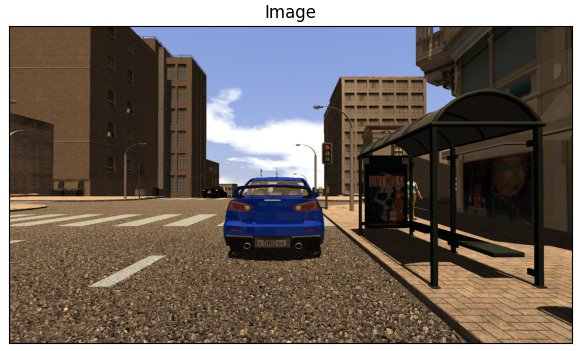

In semantic segmentation tasks `labels` and `pred_probs` are formatted with the following dimensions:

    N - Number of images in the dataset
    K - Number of classes in the dataset
    H - Height of each image
    W - Width of each image

Each pixel in the dataset is labeled with one of *K* possible classes. The `pred_probs` contain a length-*K* vector for **each** pixel in the dataset (which sums to 1 for each pixel). This results in an array of size `(N,K,H,W)`. 

Note that cleanlab requires **only** `pred_probs` from any trained segmentation model and `labels` in order to detect label errors. The `pred_probs` should be **out-of-sample**, which can be obtained for every image in a dataset via K-fold cross-validation.

**pred_probs**
dim: (N,K,H,W)

In [ ]:
pred_probs_filepaths ='predicted_masks.npy'
pred_probs = np.load(pred_probs_filepaths, mmap_mode='r+')
print(pred_probs.shape)

The `labels` contain a class label for each pixel in each image, which must be an integer in `0, 1, ..., K-1`. This results in an array of size `(N,H,W)`.

**labels**
dim: (N,H,W)

In [ ]:
label_filepaths ='given_masks.npy'
labels = np.load(label_filepaths, mmap_mode='r+')
print(labels.shape)

Note that these correspond to the labeled mask from the dataset, and the extracted probabilities of a trained classifier. If using your own dataset, which may consider iterating on memmaped numpy arrays.

- `labels`: Array of dimension (N,H,W) where N is the number of images, K is the number of classes, and H and W are dimension of the image. We assume an integer encoded image. For one-hot encoding one can `np.argmax(labels_one_hot,axis=1)` assuming that `labels_one_hot` is of dimension (N,K,H,W)
- `pred_probs`: Array of dimension (N,K,H,W), similar to `labels` where `K` is the number of classes.

**class_names**
dim: (K,)

Some of our functions optionally use the class names to improve visualization. Here are the class names in our dataset.

In [ ]:
SYNTHIA_CLASSES = ['unlabeled','sky', 'building', 'road', 'sidewalk', 'fence', 'vegetation','pole','car', \
               'traffic sign','person','bicycle','motorcycle','traffic light', 'terrain', \
               'rider',  'truck', 'bus', 'train','wall']

## 3. Use cleanlab to find label issues 

In segmentation, we consider an image mislabeled if the given mask does not match what truly appears in the image that is being segmented. More specifically, when a pixel is labeled as class `i` but the pixel _really_ belongs to class `j`. This generally happens when an image is annotated maunally by human annotators.

Below are examples of three types of annotation errors common in segmentation datasets.

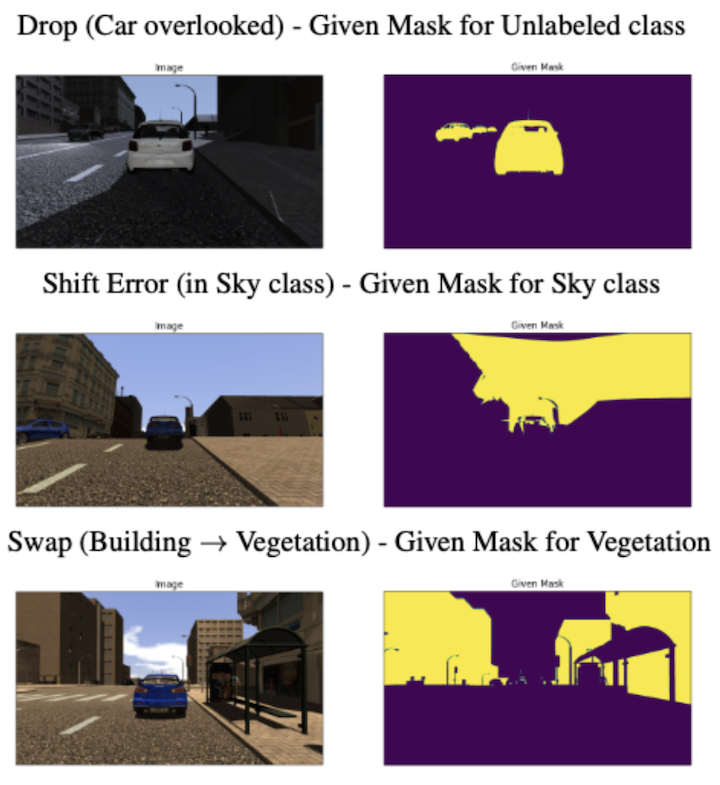


Based on the given `labels` and out-of-sample `pred_probs`, cleanlab can quickly help us identify such label issues in our dataset by calling `find_label_issues()`. 

By default, the indices of the identified label issues are sorted by cleanlab’s self-confidence score, which measures the quality of each given label via the probability assigned to it by our trained model. The returned `issues` is a boolean mask of dimension `(N,H,W)`, where `True` corresponds to a detected error sorted by image quality with the lowest-quality images coming first.

In [ ]:
issues = find_label_issues(labels, pred_probs,downsample = 16, n_jobs=None, batch_size=100000)

**Note:**
 - The ``downsample`` flag gives us compute benefits to scale to large datasets, but for maximum label error detection accuracy, keep this value low.
 - To maximize compute efficiency, try to use the largest `batch_size` your system memory allows.

### Visualize top label issues

Let's look at the top 2 images that cleanlab thinks are most likely mislabeled, namely images located at index 131 and 29. The part of image highlighted in red is where cleanlab believes the given mask does not match what really appears in the image.

In [ ]:
display_issues(issues,top=2)

We can also input `pred_probs`, `labels`, and `class_names` as auxiliary inputs to see more information.

In [ ]:
display_issues(issues, labels=labels, pred_probs=pred_probs, class_names=SYNTHIA_CLASSES,top=2)

After additionally inputting `pred_probs`, `labels`, and `class_names` we see more information:
 - Inputs `labels` and `pred_probs` generates the first two columns. This segments the image based on the class that appears in the given label and what class the model predicted for those pixels.
 - Input `class_names` creates the legend that color codes our segmentation.


In the leftmost plot we can see that the dark brown area (the `unlabeled` class as shown in the legend) was the given label. The middle plot shows our model believes that this area is infact the `sky`, a light brown shade in the legend. The rightmost plot highlights the discrepancy between these classes in red to indicate which area of the image is likely mislabeled.

These plots clearly highlight the part of the sky that was mislabeled by annotators of this image.

### Classes which are commonly mislabeled overall 

We may also wish to understand which classes tend to be most commonly mislabeled throughout the entire dataset by calling `common_label_issues()`. 

In [ ]:
common_label_issues(issues, labels=labels, pred_probs=pred_probs, class_names=SYNTHIA_CLASSES)

The printed information above is also stored in a returned pandas DataFrame, which summarizes which classes are overall least reliably labeled in the dataset.

### Focusing on one specific class

We can also just focus on issues within a specific class of interest, say just the class `car`. Easily do so using `filter_by_class` to only look at the estimated label errors in the `car` class. 
Here the color-coding reveals that the pixels depicting a car in the image were mistakenly left as the `unlabeled` class in the given label.

In [ ]:
class_issues = filter_by_class(SYNTHIA_CLASSES.index("car"), issues,labels=labels, pred_probs=pred_probs)

In [ ]:
display_issues(class_issues, pred_probs=pred_probs, labels=labels, top=3, class_names=SYNTHIA_CLASSES)

###  Get label quality scores

Cleanlab can provide an overall label quality score for each image to estimate our confidence that it is correctly labeled. These scores range from 0 to 1, such that lower scores indicate images more likely to contain some mislabeled pixels.

**Note:** To automatically estimate *which* pixels are mislabeled (and the number of label errors) rather than ranking the images, use `find_label_issues()` instead. 

The label quality scores are most useful if you only have time to review a limited number of images and want to prioritize which ones to look at, or if you're specifically aiming to detect label errors with high precision (or high recall) rather than overall estimation of the set of mislabeled images and pixels.

In [ ]:
image_scores, pixel_scores = get_label_quality_scores(labels, pred_probs)

Beyond scoring the overall label quality of each image, the above method produces a (0 to 1) quality score for each pixel. We can apply a thresholding function to these scores in order to extract the same style `True` or `False` mask as `find_label_issues()`.

In [ ]:
issues_from_score = issues_from_scores(image_scores, pixel_scores, threshold=0.5) 

In [ ]:
display_issues(issues_from_score, pred_probs=pred_probs, labels=labels, top=5) 

We can see that the errors are dominated by label errors in the sky.

In [ ]:
# Note: This cell is only for docs.cleanlab.ai, if running on local Jupyter or Colab, please ignore it.
top_2_issues = np.argsort(-np.sum(issues, axis=(1, 2)))[:2]
assert (top_2_issues == [131,  29]).all()

top_3_class_issues = np.argsort(-np.sum(class_issues, axis=(1, 2)))[:3]
assert (top_3_class_issues == [134,  66, 109]).all()

highlighted_indices = [ 78,  16, 120,  34, 137,  51,  71,   8, 106,  94]
if not all(np.argsort(issues_from_score.sum((1,2)))[:10]==highlighted_indices):
    raise Exception("Some highlighted examples are missing from ranked_label_issues.")